<a href="https://colab.research.google.com/github/Abhishek92kumar/LJMU/blob/main/Code_for_layout_parsing_and_analysis_based_on_the_dataset_Publaynet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sure, here is the code for layout parsing and analysis based on the dataset PublayNet.

In [22]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader


In [4]:
# # Download the dataset
# os.system("wget https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/publaynet.tar.gz")
# os.system("unzip -o publaynet.zip")



In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
!pip install webdataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.6 MB/s eta 0:00:00


In [7]:
import webdataset as wds
import pprint
import numpy as np
from itertools import islice
import torch
figsize(20, 10)
pp = pprint.PrettyPrinter(indent=2, compact=True, width=150, depth=2).pprint
cache_dir = None

# Loading PubLayNet from the Web

Datasets are accessible directly over the web. However, you can also store them locally, in network file systems, or in any object store.

In [ ]:
# urls = "http://storage.googleapis.com/lpr-publaynet/publaynet-train-{000000..000340}.tar"

In [8]:
urls =  "https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/publaynet.tar.gz"

Datasets are just `.tar` archives containing training files. For PubLayNet, each training sample consists of a `.png` file and a corresponding `.json` file.

In [9]:
!curl {urls} | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 95.1G  100 95.1G    0     0  42.3M      0  0:38:21  0:38:21 --:--:-- 58.3M


In [11]:
eval = "https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/labels.tar.gz"

In [10]:
# !curl {eval} | tar xz

In [12]:
# !curl -s -L https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-0.tar.gz | tar tvf - | sed 10q


In [17]:
# Create a data loader
data_dir = "publaynet"
# train_dataset = PubLayNetDataset(data_dir, "train")
# val_dataset = PubLayNetDataset(data_dir, "val")
# test_dataset = PubLayNetDataset(data_dir, "test")

train_dataset = "/content/publaynet/train"
val_dataset = "/content/publaynet/val"
test_dataset = "/content/publaynet/test"



In [18]:
# Define the model
class LayoutParser(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torchvision.models.resnet50(pretrained=True)
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 5),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x


In [19]:

# Create the model
model = LayoutParser()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


In [20]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [25]:
# create dataloader
num_epochs = 15
num_classes= 10
batch_size = 128
lr = 0.001

train_loader = DataLoader(dataset=train_dataset, batch_size= batch_size,shuffle=True) 



test_loader = DataLoader(dataset=test_dataset,  batch_size= batch_size,shuffle=True) 

'/content/publaynet/train'

In [27]:

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_acc += (predicted == labels).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch {}: train loss {:.4f}, train acc {:.4f}".format(epoch + 1, train_loss / len(train_loader), train_acc / len(train_loader)))



ValueError: ignored

In [ ]:
# Evaluate the model
val_loss = 0
val_acc = 0
for i, (images, labels) in enumerate(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
    _, predicted = outputs.max(1)
    val_acc += (predicted == labels).sum().item()
print("Val loss {:.4f}, val acc {:.4f}".format(val_loss / len(val_loader), val_acc / len(val_loader)))



In [ ]:
# Save the model
torch.save(model.state_dict(), "model.pt")



In [ ]:
# Create a tensorboard writer
writer = SummaryWriter()



In [ ]:
# Write the training loss and accuracy to tensorboard
for epoch in range(num_epochs):
    writer.add_scalar("train_loss", train_loss / len(train_loader), epoch)
    writer.add_scalar("train_acc", train_acc / len(train_loader), epoch)



In [ ]:
# Write the validation loss and accuracy to tensorboard
writer.add_scalar("val_loss", val_loss / len(val_loader), epoch)
writer.add_scalar("val_acc", val_acc / len(val_loader), epoch)



In [ ]:
# Close the tensorboard writer
writer.close()


In [ ]:

# Run the code step by step
if __name__ == "__main__":
    # Download the dataset
    os.system("wget https://data.deepai.org/publaynet.zip")
    os.system("unzip -o publaynet.zip")

    # Create a data loader
    data_dir = "publ"

<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://github.com/boostcampaitech3/level1-image-classification-level1-nlp-07">https://github.com/boostcampaitech3/level1-image-classification-level1-nlp-07</a></li>
  <li><a href="https://blog.csdn.net/znsoft/article/details/123960223">https://blog.csdn.net/znsoft/article/details/123960223</a></li>
  <li><a href="https://blog.csdn.net/juanjuanyou/article/details/121731241">https://blog.csdn.net/juanjuanyou/article/details/121731241</a></li>
  <li><a href="https://github.com/ccoltong1215/simple-lenet5-torch-mnist">https://github.com/ccoltong1215/simple-lenet5-torch-mnist</a> subject to MIT</li>
  <li><a href="https://github.com/qhannan/crc_tumor_msi">https://github.com/qhannan/crc_tumor_msi</a></li>
  <li><a href="https://github.com/WakuHatakeyama/kmnist">https://github.com/WakuHatakeyama/kmnist</a></li>
  <li><a href="https://github.com/Chen-Zuquan/Pretraining-Practice">https://github.com/Chen-Zuquan/Pretraining-Practice</a></li>
  </ol>
</div>

In [33]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import tarfile
import urllib
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import random
import shutil

In [34]:

# Define the Dataset class
class PublaynetDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.root_dir, file_name)
        # Load and preprocess the document image here
        # Implement any necessary data transformations

        # Return the preprocessed image and corresponding labels
        return image, labels

# Define the deep neural network model
class DocumentLayoutNet(nn.Module):
    def __init__(self, num_classes):
        super(DocumentLayoutNet, self).__init__()
        # Define the architecture of your deep neural network here

    def forward(self, x):
        # Implement the forward pass of your model
        return x

def create_test_file(train_dir, test_dir, test_ratio=0.2):
    file_list = os.listdir(train_dir)
    random.shuffle(file_list)
    test_size = int(len(file_list) * test_ratio)
    test_files = file_list[:test_size]

    os.makedirs(test_dir, exist_ok=True)
    for file_name in test_files:
        src = os.path.join(train_dir, file_name)
        dst = os.path.join(test_dir, file_name)
        shutil.move(src, dst)


In [35]:

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download and extract the Publaynet dataset
# url = "https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-0.tar.gz"
# urllib.request.urlretrieve(url, "train-0.tar.gz")
# with tarfile.open("train-0.tar.gz", "r:gz") as tar:
#     tar.extractall()
# os.remove("train-0.tar.gz")




In [37]:
# Create the train and test datasets
train_dir = "/content/publaynet/train"
test_dir = "/content/publaynet/test"
create_test_file(train_dir, test_dir)

# Define the train and test datasets
train_dataset = PublaynetDataset(train_dir)
test_dataset = PublaynetDataset(test_dir)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [46]:
# Define the model, criterion, optimizer
# Define the deep neural network model
class DocumentLayoutNet(nn.Module):
    def __init__(self, num_classes):
        super(DocumentLayoutNet, self).__init__()
        # Define the architecture of your deep neural network here
        
model = DocumentLayoutNet(num_classes=3)  # Adjust the number of classes accordingly
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)



ValueError: ignored

In [ ]:
# Define the training loop
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

In [ ]:

# Define the evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')

    return avg_loss, accuracy, f1, precision, recall

# Train and evaluate the model
num_epochs = 10
train_losses = []
test_losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy, f1, precision, recall = evaluate_model(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Plot the training and testing losses
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the evaluation metrics
plt.plot(accuracies, label="Accuracy")
plt.plot(f1_scores, label="F1 Score")
plt.plot(precisions, label="Precision")
plt.plot(recalls, label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend()
plt.show()


### New Try

In [63]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import tarfile
import urllib
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import random
import shutil

# Define the Dataset class
class PublaynetDataset(Dataset):
    def __init__(self, root_dir):
    
      self.root_dir = root_dir
      self.file_list = os.listdir(root_dir)

    def __len__(self):
    
      return len(self.file_list)

    def __getitem__(self, idx):
      file_name = self.file_list[idx]
      file_path = os.path.join(self.root_dir, file_name)
      # Load and preprocess the document image here
        # Implement any necessary data transformations

        # Return the preprocessed image and corresponding labels
      return image, labels

# Define the deep neural network model
class DocumentLayoutNet(nn.Module):
    def __init__(self, num_classes):
        super(DocumentLayoutNet, self).__init__()
        # Define the architecture of your deep neural network here

    def forward(self, x):
        # Implement the forward pass of your model
        return x

def create_test_file(train_dir, test_dir, test_ratio=0.2):
    file_list = os.listdir(train_dir)
    random.shuffle(file_list)
    test_size = int(len(file_list) * test_ratio)
    test_files = file_list[:test_size]

    os.makedirs(test_dir, exist_ok=True)
    for file_name in test_files:
        src = os.path.join(train_dir, file_name)
        dst = os.path.join(test_dir, file_name)
        shutil.move(src, dst)

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download and extract the Publaynet dataset
# url = "https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-0.tar.gz"
# urllib.request.urlretrieve(url, "train-0.tar.gz")
# with tarfile.open("train-0.tar.gz", "r:gz") as tar:
#     tar.extractall()
# os.remove("train-0.tar.gz")

# Create the train and test datasets
train_dir = "/content/publaynet/train"
test_dir = "/content/publaynet/test"
create_test_file(train_dir, test_dir)

# Define the train and test datasets
train_dataset = PublaynetDataset(train_dir)
test_dataset = PublaynetDataset(test_dir)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model, criterion, optimizer
model = DocumentLayoutNet(num_classes=3)  # Adjust the number of classes accordingly
model = model.to(device)
criterion = nn.CrossEntropyLoss()


In [60]:
 for labels in train_loader:
        # images = images.to(device)
  labels = labels.to(device)

NameError: ignored

In [56]:
train_loader

In [64]:
from PIL import Image

def load_image(file_path):
    # Load the image using a library like PIL or OpenCV
    image = Image.open(file_path)
    # Convert the image to the desired format if necessary
    image = image.convert('RGB')
    return image

def preprocess_image(image):
    # Apply any necessary preprocessing steps to the image
    transformed_image = transforms.ToTensor()(image)
    # Normalize the image if required
    normalized_image = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                            std=[0.229, 0.224, 0.225])(transformed_image)
    return normalized_image


NameError: ignored

In [67]:
# optimizer = optim.Adam(model.parameters(), lr=0.001)

model = LayoutParser() # used as an alternative 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Define the training loop
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    return running_loss / len(train_loader)

# Define the evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')

    return avg_loss, accuracy, f1, precision, recall

# Train and evaluate the model
num_epochs = 10
train_losses = []
test_losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy, f1, precision, recall = evaluate_model(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Plot the training and testing losses
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the evaluation metrics
plt.plot(accuracies, label="Accuracy")
plt.plot(f1_scores, label="F1 Score")
plt.plot(precisions, label="Precision")
plt.plot(recalls, label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend()
plt.show()


NameError: ignored

FileNotFoundError: ignored

### New start from kaggle https://www.kaggle.com/code/ammarnassanalhajali/layout-parsing-starter/notebook

# **Layout Parsing starter**

# Install the LayoutParser library

In [71]:
!pip install -U layoutparser 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 kB 13.2 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=b09318a60df744c4bccc233a7f6d8b326c99c00f09be9e70aa2ad2c59e4a2570
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pi

# Load COCO Layout Annotations And Layoutparser

In [1]:
!pip install layoutparser[ocr]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-7t9hfa72/detectron2_9c0def3489e54b21bd6d2cb3dbb9bf60
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-7t9hfa72/detectron2_9c0def3489e54b21bd6d2cb3dbb9bf60
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for 

In [3]:
def load_coco_annotations(annotations, coco=None):
    """
    Args:
        annotations (List):
            a list of coco annotaions for the current image
        coco (`optional`, defaults to `False`):
            COCO annotation object instance. If set, this function will
            convert the loaded annotation category ids to category names
            set in COCO.categories
    """
    layout = lp.Layout()

    for ele in annotations:

        x, y, w, h = ele['bbox']

        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type  = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )

    return layout

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import cv2
import random
import json
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt


from pycocotools.coco import COCO
import layoutparser as lp


# Preparing Dataset

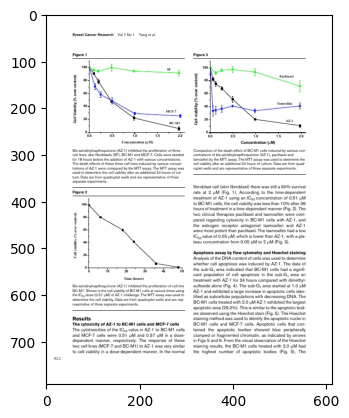

In [5]:
imgdir="/content/publaynet/train"
image = cv2.imread('/content/publaynet/train/PMC1064093_00003.jpg')
plt.imshow(image)

In [6]:
f = open('/content/publaynet/train.json',)
thing_classes  = []
category_name_to_id = {}
data_annotations=[]
data = json.load(f)
#----Images----
data_images=data['images']
#---annotations-
for i in data['annotations']:
    annot_obj ={"id": i['id'],"image_id": i['image_id'],"category_id":i['category_id'],
          "x_min":i['bbox'][0], #left
          "y_min":i['bbox'][1], #top
          "x_max":i['bbox'][0]+i['bbox'][2], #left+width
          "y_max":i['bbox'][1]+i['bbox'][3] #top+hieght
         }
    data_annotations.append(annot_obj) 
#---categories-
for i in data['categories']:
    thing_classes.append(i['name'])
    category_name_to_id[i['name']]=i['id']
f.close()
print("thing_classes=",thing_classes)
print("category_name_to_id=",category_name_to_id)

thing_classes= ['text', 'title', 'list', 'table', 'figure']
category_name_to_id= {'text': 1, 'title': 2, 'list': 3, 'table': 4, 'figure': 5}


In [7]:
train_meta = pd.DataFrame(data_images)
train_meta = train_meta[['id', 'file_name', 'width', 'height']]
train_meta = train_meta.rename(columns={"id":"image_id"})
print("train_meta size=",len(train_meta))
train_meta.head(3)

train_meta size= 335703


,image_id,file_name,width,height
0,0,PMC3866684_00003.jpg,613,811
1,1,PMC3866684_00001.jpg,613,811
2,2,PMC3866684_00002.jpg,613,811


In [8]:
train_df = pd.DataFrame(data_annotations)
print("train_df size=",len(train_df))
train_df.head(3)

train_df size= 3263046


,id,image_id,category_id,x_min,y_min,x_max,y_max
0,0,0,1,40.42,444.87,291.97,508.73
1,1,0,1,309.91,444.91,561.46,466.88
2,2,0,1,40.42,507.66,291.97,540.11


## Understading Dataset

In [9]:
COCO_ANNO_PATH = '/content/publaynet/train.json'
COCO_IMG_PATH  = '/content/publaynet/train'

coco = COCO(COCO_ANNO_PATH)

loading annotations into memory...
Done (t=72.10s)
creating index...
index created!


## Visualizing Layouts

<ipython-input-10-7fca18386350>:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for image_id in random.sample(coco.imgs.keys(), 1):


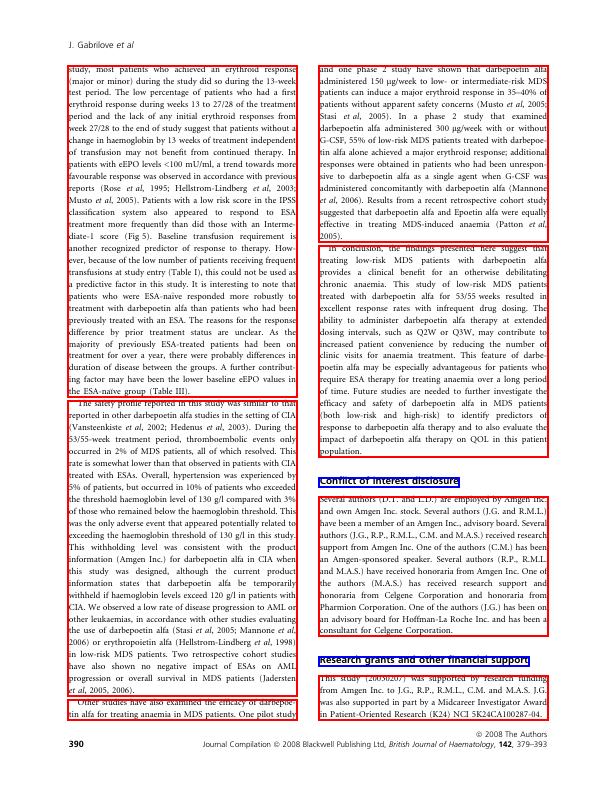

In [10]:
color_map = {
    'text':   'red',
    'title':  'blue',
    'list':   'green',
    'table':  'yellow',
    'figure': 'pink',
}


for image_id in random.sample(coco.imgs.keys(), 1):
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))

    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    layout = load_coco_annotations(annotations, coco)

    viz = lp.draw_box(image, layout, color_map=color_map)
    display(viz) # show the results

# Model Predictions on Loaded Data

In [11]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "text", 1: "title", 2: "list", 3:"table", 4:"figure"})

config.yml?dl=1: 8.19kB [00:01, 4.84kB/s]
model_final.pth?dl=1: 330MB [01:14, 4.46MB/s]                           


# Detecting The Figure Part of Our Image

# Detecting Layouts

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


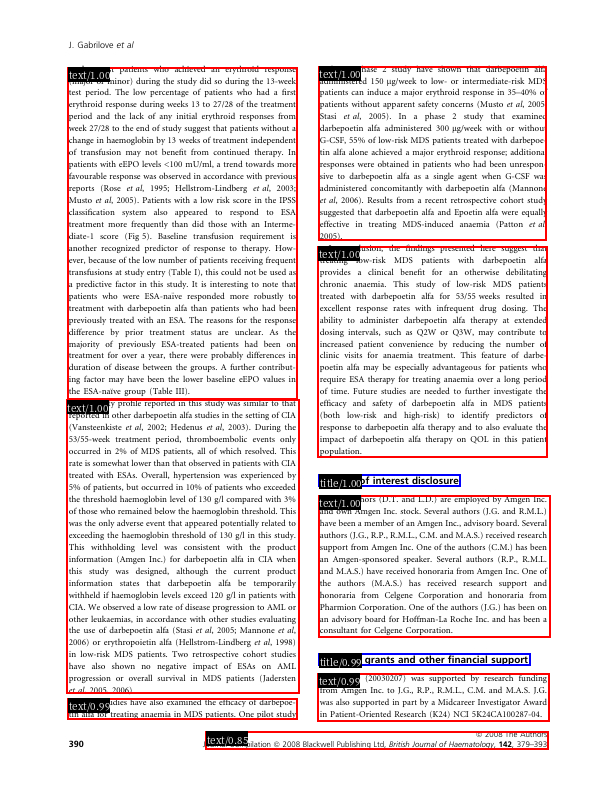

In [12]:
layout_predicted = model.detect(image)
lp.draw_box(image,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=color_map,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

In [14]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [15]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.0.1+cu118 False


# importing libraries

In [16]:
import pandas as pd
import numpy as np
import pandas as pd 
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
#from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional


# torch
import torch

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#from pycocotools.coco import COCO
from sklearn.model_selection import StratifiedKFold

# glob
from glob import glob

# numba
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<Logger detectron2 (DEBUG)>

# configs

In [17]:
imgdir="/content/publaynet/train"

debug=False
split_mode="valid20" # all_train Or  valid20 
image_Width=601
image_Height=792

num_folds=5
Selected_fold=1 #1,2,3,4,5 

In [18]:
def get_PL_data_dicts(
    imgdir: Path,
    _train_df: pd.DataFrame,
    _train_meta: pd.DataFrame,
    use_cache: bool = True,
    target_indices: Optional[np.ndarray] = None,
    debug: bool = False,
    data_type:str="train"
   
):
    if debug:
            train_meta = train_meta.iloc[:100]  # For debug...
    dataset_dicts = []
    for index, train_meta_row in tqdm(_train_meta.iterrows(), total=len(_train_meta)):
                    record = {}
                    image_id,file_name, width,height = train_meta_row.values
                    filename = str(f'{imgdir}/{file_name}')
                    record["file_name"] = filename
                    record["image_id"] = image_id
                    record["width"] = width
                    record["height"] = height
                    objs = []
                    for index2, row in _train_df.query("image_id == @image_id").iterrows():
                        class_id = row["category_id"]
                        bbox_resized = [
                            float(row["x_min"]),
                            float(row["y_min"]),
                            float(row["x_max"]),
                            float(row["y_max"]),
                        ]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    record["annotations"] = objs
                    dataset_dicts.append(record)
                    
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

                                  

In [19]:
Data_Resister_training="PL_data_train";
Data_Resister_valid="PL_data_valid";

if split_mode == "all_train":
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    
    
    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)
    
    
elif split_mode == "valid20":

    n_dataset = len(train_meta)
    n_train = int(n_dataset * 0.95)
    print("n_dataset", n_dataset, "n_train", n_train)
    rs = np.random.RandomState(12)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=train_inds,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    

    DatasetCatalog.register(
        Data_Resister_valid,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=valid_inds,
            debug=debug,
            data_type="val"
            ),
        )
    MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    
    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

    dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
    metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)
    
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")

n_dataset 335703 n_train 318917


  0%|          | 0/335703 [00:00<?, ?it/s]

  0%|          | 0/335703 [00:00<?, ?it/s]

In [20]:
print("dicts training size=",len(dataset_dicts_train),"################  dicts valid size=",len(dataset_dicts_valid))

dicts training size= 318917 ################  dicts valid size= 16786


In [21]:
dataset_dicts_train[11]

{'file_name': '/content/publaynet/train/PMC4609949_00012.jpg',
 'image_id': 19706,
 'width': 596,
 'height': 783,
 'annotations': [{'bbox': [155.64, 48.22, 556.8199999999999, 71.55],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [155.64, 132.23, 556.8, 166.04999999999998],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [155.64, 163.73, 556.76, 208.04],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [155.64, 268.73, 556.8499999999999, 313.04],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [155.64, 326.0, 556.81, 349.46],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [155.64, 347.07, 556.8399999999999, 370.46],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [155.64, 395.57, 355.92999999999995, 408.40999999999997],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [155.64, 406.08, 556.8, 450.39],
   'bb

In [22]:
dataset_dicts_valid[0]

{'file_name': '/content/publaynet/train/PMC5095923_00005.jpg',
 'image_id': 182534,
 'width': 596,
 'height': 789,
 'annotations': [{'bbox': [102.05, 76.8, 552.73, 99.86],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [102.05, 100.78, 552.74, 207.86],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [102.05, 208.78, 552.8, 303.84000000000003],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [102.05, 304.82, 552.75, 447.84000000000003],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [102.05, 448.82, 552.78, 579.8199999999999],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [102.04, 580.57, 552.75, 675.86],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [102.05, 700.82, 552.74, 723.82],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [102.05, 682.36, 491.22, 700.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,


# Data Visualization

In [25]:
d=dataset_dicts_valid[1]   
d

{'file_name': '/content/publaynet/train/PMC5483170_00003.jpg',
 'image_id': 100126,
 'width': 612,
 'height': 792,
 'annotations': [{'bbox': [150.0, 61.3, 524.21, 268.84],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [150.0, 283.53, 522.64, 491.11],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [150.0, 505.68, 520.39, 657.38],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0}]}

(0.0, 1.0, 0.0, 1.0)

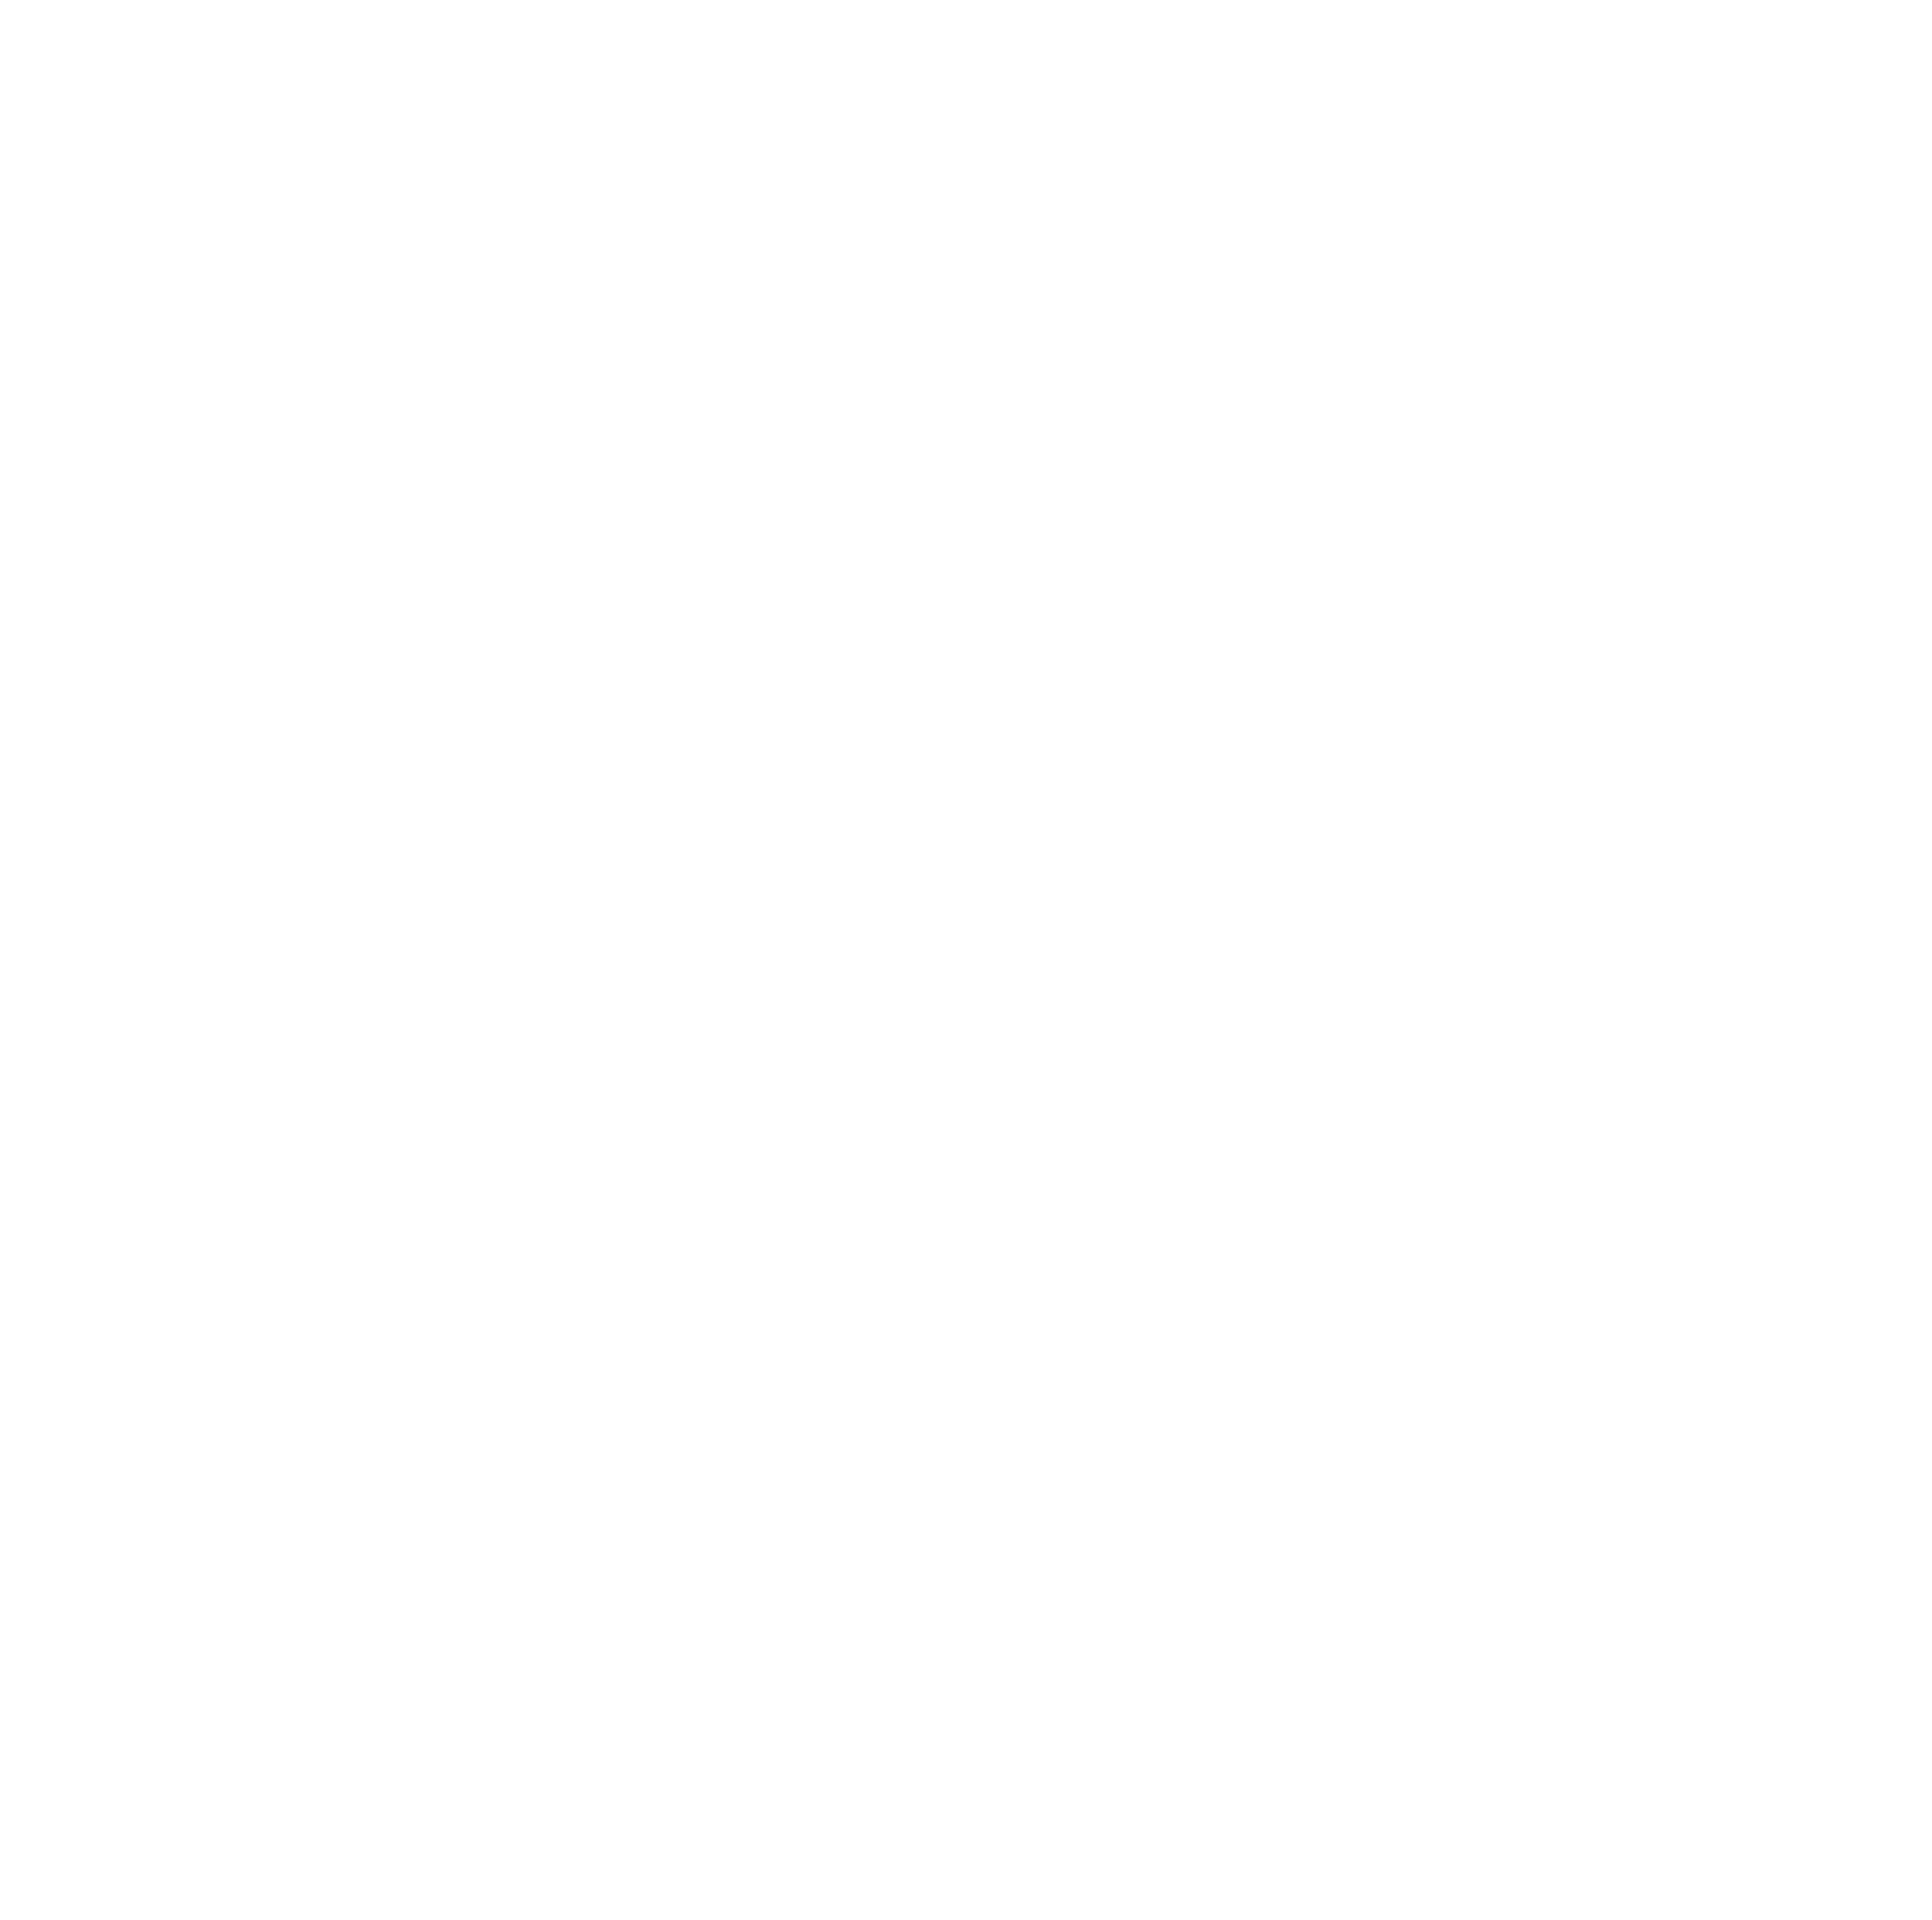

In [27]:
fig = plt.figure(figsize =(40,40))
ax = fig.add_subplot(1,1,1)

d=dataset_dicts_valid[1]   
img = cv2.imread(d["file_name"])
v = Visualizer(img[:, :, ::-1],
                metadata=metadata_dicts_valid, 
                scale=1.5, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
# out = v.draw_dataset_dict(d)
ax.grid(False)
ax.axis('off')
# ax.imshow(out.get_image()[:, :, ::-1])

# Data Augmentation

In [29]:
def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.RandomBrightness(0.8, 1.2),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [30]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 

cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = (Data_Resister_training,)

if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = (Data_Resister_valid,)
    cfg.TEST.EVAL_PERIOD = 1000

cfg.DATALOADER.NUM_WORKERS = 0
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.MODEL.WEIGHTS="/kaggle/input/layout-parser-weights/Weights/mask_rcnn_R_50_FPN_3x/model_final.pth"

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025

cfg.SOLVER.WARMUP_ITERS = 10
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (500, 1000) # must be less than  MAX_ITER 
cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
trainer = AugTrainer(cfg) 
#trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: ignored

In [ ]:
evaluator = COCOEvaluator(Data_Resister_training, cfg, False, output_dir="./output/")
cfg.MODEL.WEIGHTS="./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
val_loader = build_detection_test_loader(cfg, Data_Resister_training)
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T

In [ ]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

In [ ]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

In [ ]:
fig, ax = plt.subplots()
mdf1 = mdf[~mdf["loss_box_reg"].isna()]
ax.plot(mdf1["iteration"], mdf1["loss_box_reg"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("loss_box_reg")
plt.show()

In [ ]:
import layoutparser as lp

In [ ]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 './output/model_final.pth',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0:"None",1: "text", 2: "title", 3: "list", 4:"table", 5:"figure"})
#######################################################
image = cv2.imread('/content/publaynet/train/PMC1064093_00003.jpg')
#plt.imshow(image)
color_map = {
    'text':   'red',
    'title':  'blue',
    'list':   'green',
    'table':  'yellow',
    'figure': 'pink',
}

layout_predicted = model.detect(image)
lp.draw_box(image,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=color_map,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

In [ ]:
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
#cfg.DATASETS.TEST = ("Data_Resister_training", )
predictor = DefaultPredictor(cfg)

###############################################################

fig, ax = plt.subplots(2, 2, figsize =(20,20))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 4
samples = random.sample(dataset_dicts_train, NUM_TEST_SAMPLES)
for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=metadata_dicts_train,scale=0.5,)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu"))
    display_img = visualizer.get_image()[:, :, ::-1]
    indices[i].grid(False)
    indices[i].imshow(display_img)